In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)
# colors = ["#95D3A2", "#FFFFBF", "#F79051", ]
colors = ["#5657A4", "#95D3A2", "#FFFFBF", "#F79051", "#A30644"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

SAVE_PATH = r"E:\MS_ExperimentData\general"
# SAVE_PATH = r"D:\MS_ExperimentData\general"

In [14]:
pathShift = 25
center = 100
patternHalfLength = 20
nodePosition = np.array([
    [100 - pathShift, 100], [100 + pathShift, 100]
])

model = PathPlanningGSC(
    nodePosition=nodePosition,
    # nodePosition=np.array([]),
    productRateBetac=1, decayRateKc=0.001, 
    diffusionRateDc=0.1, convectionVc=-0.1, 
    cDecayBase=1, cControlThres=0.05,
    noiseRateBetaDp=0., initialState=1, chemoAlphaC=-5,
    diameter=3, repelPower=2, repCutOff=True, deltaSpread=True,
    cellNumInLine=200, boundaryLength=200, agentsNum=200,
    tqdm=True, dt=0.1, savePath=SAVE_PATH, shotsnaps=100, overWrite=True
)

model.run(100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
self = model
positionX = self.positionX
internalState = self.internalState
c = self.c

_, ax = plt.subplots(figsize=(8, 5))

stateColors = cmap(internalState)

for i in range(self.agentsNum):
    ax.add_artist(plt.Circle(
        positionX[i], model.diameter / 2 * 0.95, zorder=1, 
        facecolor="#9BD5D5", edgecolor="black"
        # facecolor=stateColors[i], edgecolor="black"
    ))
diffX = positionX.mean(axis=0) - positionX
phi = np.arctan2(diffX[:, 1], diffX[:, 0])
ax.quiver(
    positionX[:, 0], positionX[:, 1],
    np.cos(phi), np.sin(phi), 
    # facecolor=stateColors, edgecolor="black",
    facecolor="#49B2B2", edgecolor="black",
    width=0.003, scale=70, #linewidth=0.5
)

sc = plt.scatter(np.full_like(internalState, -1), np.full_like(internalState, -1), 
                 c=internalState, cmap=cmap, vmin=0, vmax=1)
plt.colorbar(sc, ax=ax, label="Internal State")
ax.set_xlim(0, self.boundaryLength)
ax.set_ylim(0, self.boundaryLength)

im = ax.imshow(c.T, cmap=cmap, 
               extent=(0, self.boundaryLength, 0, self.boundaryLength),
               origin="lower", alpha=1, zorder=0)
plt.colorbar(im, ax=ax, label="Chemical Concentration")
plt.tight_layout()

(0.0, 200.0)

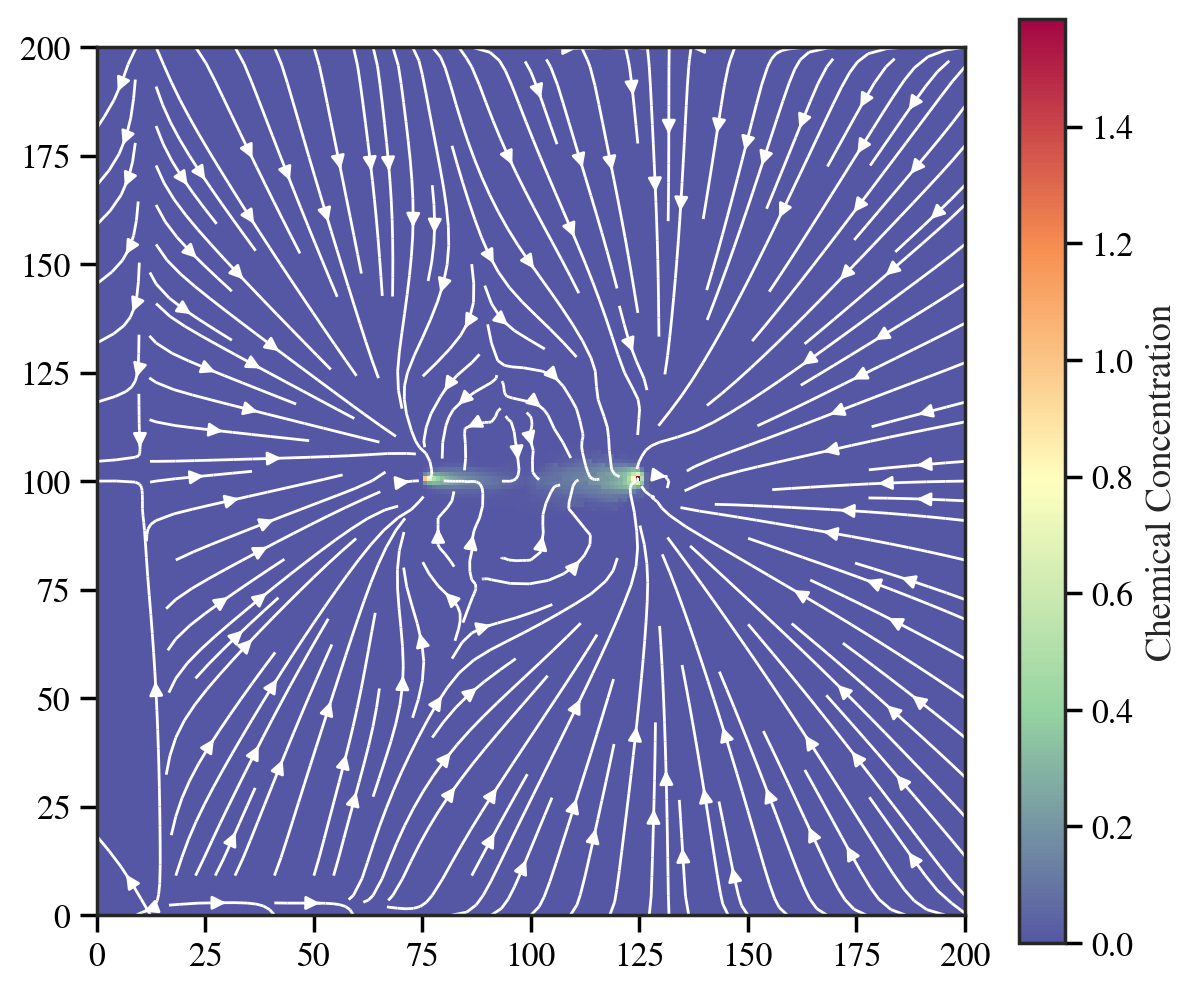

In [16]:
_, ax = plt.subplots(figsize=(7, 6))
adjMulti = model.cellNumInLine / model.boundaryLength
cPosition = model.cPosition.reshape(model.cellNumInLine, model.cellNumInLine, 2)
X = cPosition[:, :, 0].T * adjMulti
Y = cPosition[:, :, 1].T * adjMulti
c = model.c.T
U = np.roll(c, -1, axis=1) - np.roll(c, 1, axis=1)
V = np.roll(c, -1, axis=0) - np.roll(c, 1, axis=0)
im = ax.imshow(model.c.T, cmap=cmap, 
               extent=(0, self.boundaryLength, 0, self.boundaryLength),
               origin="lower", alpha=1, zorder=0)
plt.colorbar(im, ax=ax, label="Chemical Concentration")
ax.streamplot(X, Y, U, V, color="white", linewidth=1, density=1.5)
ax.set_xlim(0, self.boundaryLength)
ax.set_ylim(0, self.boundaryLength)

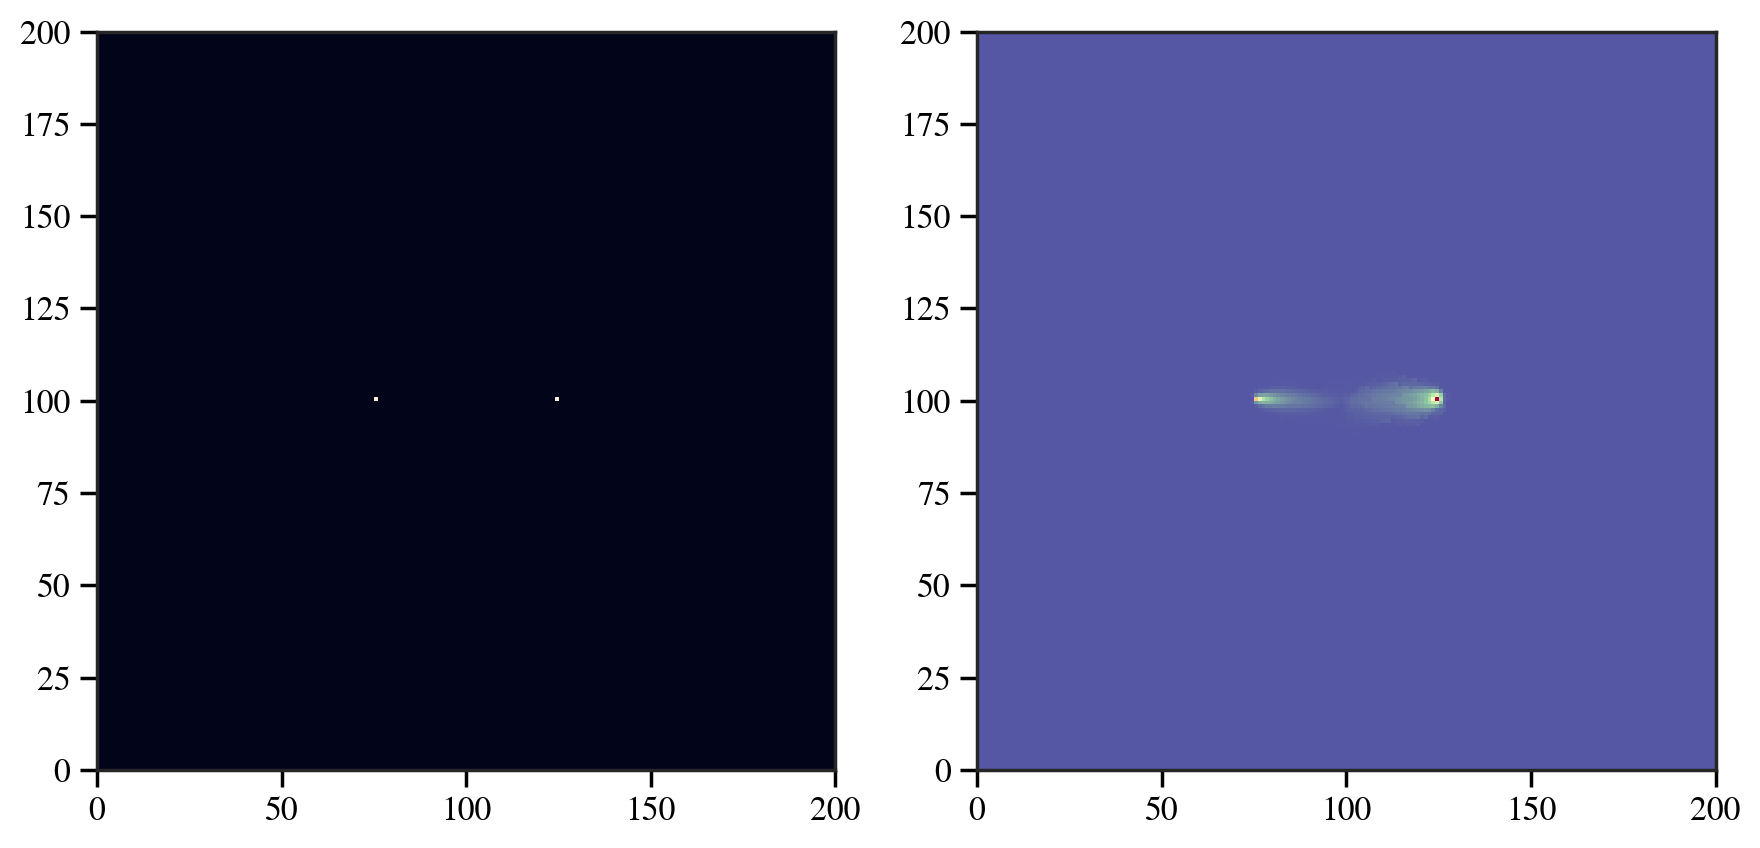

In [17]:
_, axs = plt.subplots(1, 2, figsize=(9, 4.5))

ax = axs[0]
ax.imshow(model.temp["productDeltaNode"].T, 
               extent=(0, self.boundaryLength, 0, self.boundaryLength),
               origin="lower", alpha=1, zorder=0)

ax = axs[1]
im = ax.imshow(model.c.T, cmap=cmap, 
               extent=(0, self.boundaryLength, 0, self.boundaryLength),
               origin="lower", alpha=1, zorder=0)
# plt.colorbar(im, ax=ax, label="Chemical Concentration")

for ax in axs:
    ax.set_xlim(0, self.boundaryLength)
    ax.set_ylim(0, self.boundaryLength)
    # ax.set_xticks([])
    # ax.set_yticks([])
plt.tight_layout()

(0.0, 200.0)

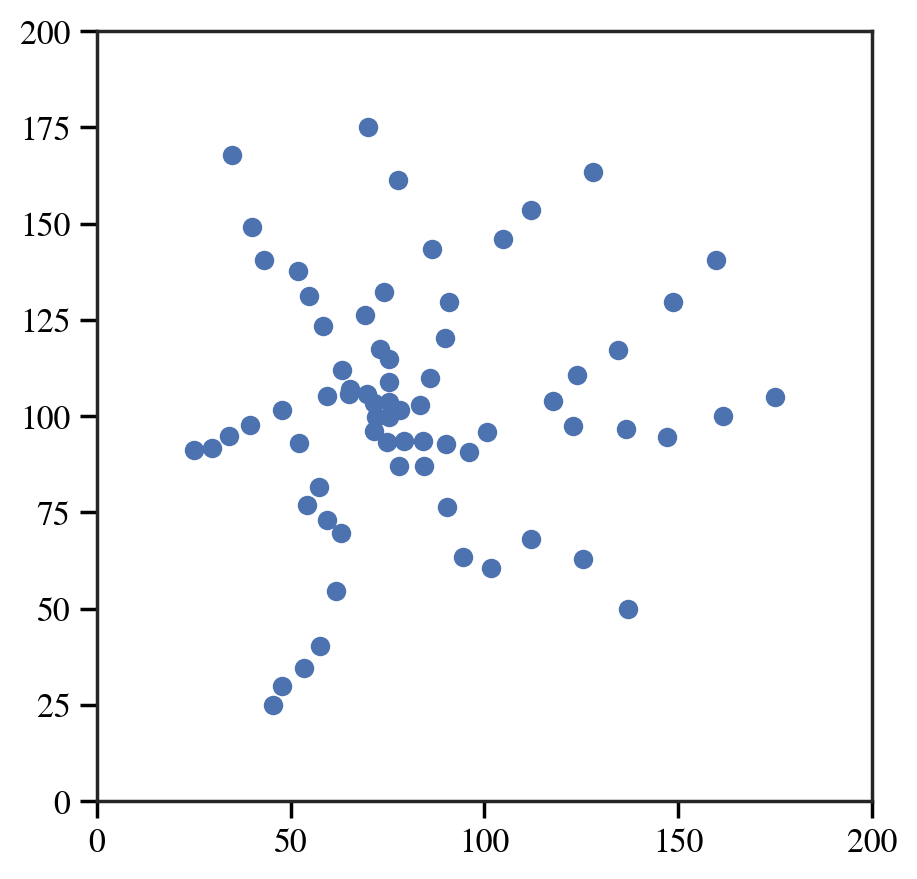

In [4]:
nodes = pd.read_parquet("Washington_Metrorail.parquet")
nodePosition = nodes[["lon", "lat"]].values
center = 100
patternHalfLength = 75
nodePosition = nodePosition - np.min(nodePosition, axis=0)
nodePosition = nodePosition / np.max(nodePosition, axis=0) * patternHalfLength * 2 + center - patternHalfLength

plt.figure(figsize=(5, 5))
plt.scatter(nodePosition[:, 0], nodePosition[:, 1])
plt.xlim(0, center * 2)
plt.ylim(0, center * 2)

In [ ]:
model = PathPlanningGSC(
    nodePosition=nodePosition,
    # nodePosition=np.array([]),
    productRateBetac=1, decayRateKc=0.001, 
    diffusionRateDc=0.5, convectionVc=0., 
    cDecayBase=1, cControlThres=0.1,
    noiseRateBetaDp=0., initialState=0.01, chemoAlphaC=-5,
    diameter=3, repelPower=2, repCutOff=True, deltaSpread=True,
    cellNumInLine=200, boundaryLength=200, agentsNum=200,
    tqdm=True, dt=0.1, savePath=SAVE_PATH, shotsnaps=100, overWrite=True
)

model.run(100000)

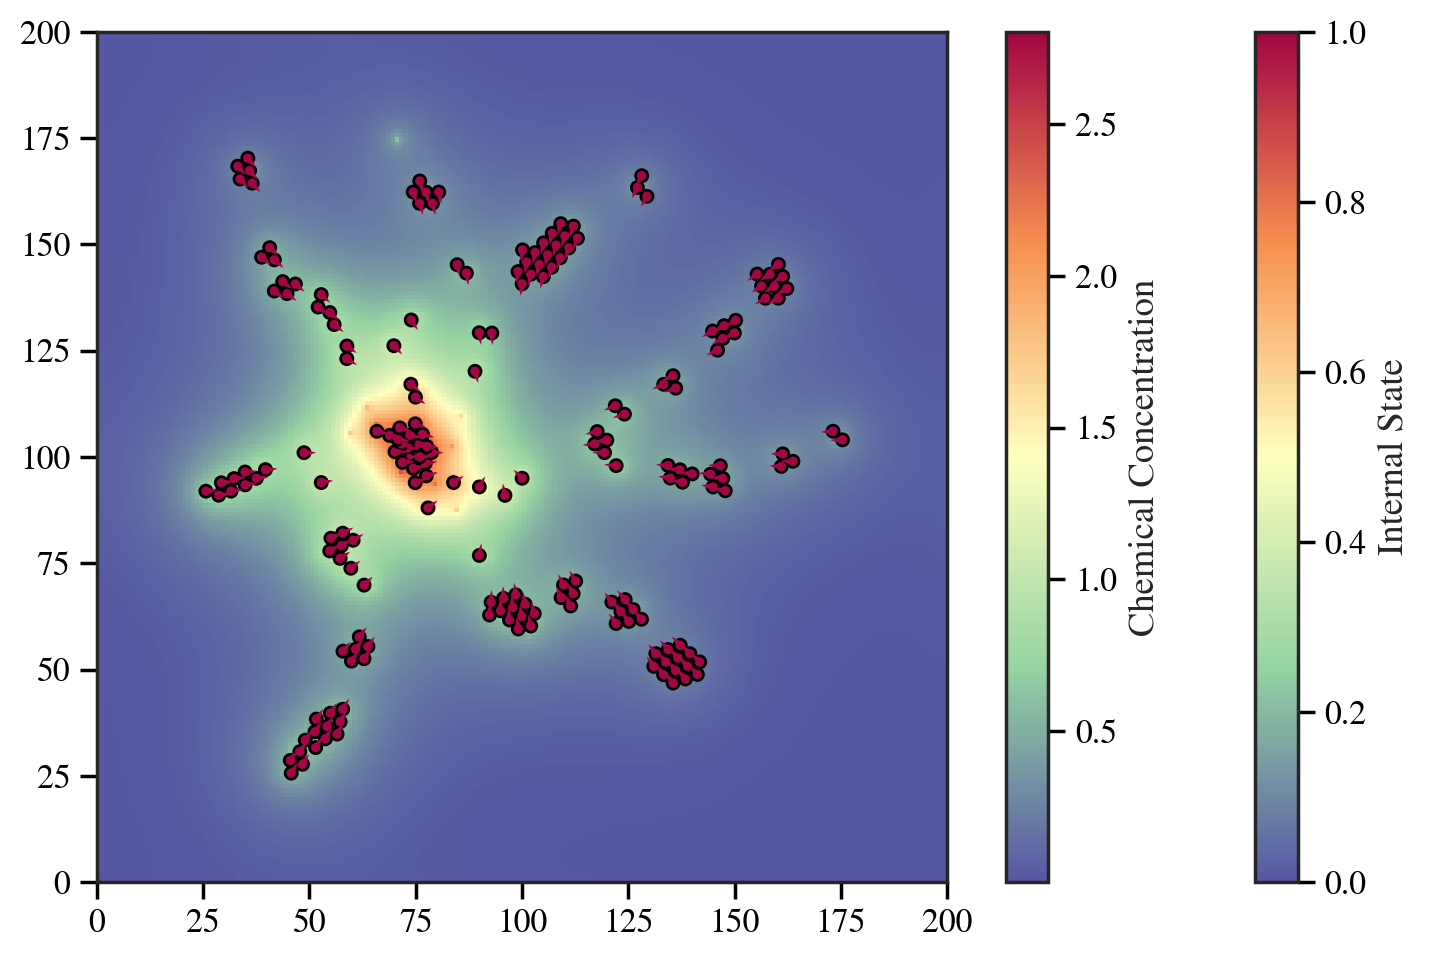

In [6]:
self = model
positionX = self.positionX
internalState = self.internalState
c = self.c

_, ax = plt.subplots(figsize=(8, 5))

stateColors = cmap(internalState)

for i in range(self.agentsNum):
    ax.add_artist(plt.Circle(
        positionX[i], model.diameter / 2 * 0.95, zorder=1, 
        facecolor=stateColors[i], edgecolor="black"
    ))
diffX = positionX.mean(axis=0) - positionX
phi = np.arctan2(diffX[:, 1], diffX[:, 0])
ax.quiver(
    positionX[:, 0], positionX[:, 1],
    np.cos(phi), np.sin(phi), 
    facecolor=stateColors, edgecolor="black",
    width=0.003, scale=70, #linewidth=0.5
)

sc = plt.scatter(np.full_like(internalState, -1), np.full_like(internalState, -1), 
                 c=internalState, cmap=cmap, vmin=0, vmax=1)
plt.colorbar(sc, ax=ax, label="Internal State")
ax.set_xlim(0, self.boundaryLength)
ax.set_ylim(0, self.boundaryLength)

im = ax.imshow(c.T, cmap=cmap, 
               extent=(0, self.boundaryLength, 0, self.boundaryLength),
               origin="lower", alpha=1, zorder=0)
plt.colorbar(im, ax=ax, label="Chemical Concentration")
plt.tight_layout()